#### **Inflation Forecasting**

**Author: Fabián Villarreal Sosa**

Notebook to compare between machine learning models and classic econometric models to forecast inflation in Ecuador.

References: 
Araujo, G. S., & Gaglianone, W. P. (2020). Machine learning methods for inflation forecasting in Brazil: New contenders versus classical models. *CEMLA*.
[Paper](https://www.cemla.org/actividades/2020-final/2020-10-xxv-meeting-cbrn/Session%202/3.%20Machine_Learning...%20Wagner%20Piazza.pdf)

In [1]:
# Librerias
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import mplcursors
import seaborn as sns

import datetime as dt

from sklearn import (linear_model, metrics, neural_network, pipeline, preprocessing, model_selection)
import statsmodels.formula.api as sm

from xgboost import XGBRegressor, plot_importance

C:\Users\fvill\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


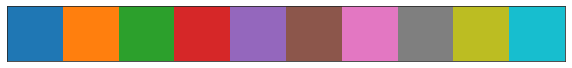

In [2]:
# Graphics style
sns.set_style('white')
csfont = {'fontname':'Calibri'}

# Color palette
my_palette = ['#4472C4', '#ED7D31', '#A5A5A5', '#FFC000', '#5B9BD5', '#70AD47', '#264478', '#9E480E', '#636363', '#997300'] # Excel color palette
my_palette2 = sns.color_palette('tab10')
sns.palplot(sns.color_palette('tab10'))

# Define palette
sns.set_palette(my_palette2)

In [3]:
# Change directory
os.chdir('C:/Users/fvill/Dropbox/DS_ML_Projects/Inflation_Forecasting/Data')
os.getcwd()

'C:\\Users\\fvill\\Dropbox\\DS_ML_Projects\\Inflation_Forecasting\\Data'

In [4]:
# Data
df = pd.read_csv('final_dataframe_ipc.csv')

print(df.shape)
df.head()

(213, 50)


,date,ipc,ind_man,ind_com,ind_con,ind_ser,iae_np,ideac_ct,ideac_sb,base_mon,...,TNX,pos_divisas,oro_monetario,DEGs,pos_reserva_FMI,pos_ALADI,pos_sucre,res_internacional,ipp,ipcons
0,2004-01-01,65.95,102.870594,103.509825,96.533766,106.319005,101.967123,77.748841,74.175894,2648.634643,...,4.150500,868.32,337.70,10.43,25.41,-1.44,NaN,1240.42,61.89,141.53
1,2004-02-01,66.40,106.416805,104.178680,97.211906,107.276700,103.401263,78.399193,70.401638,2674.554642,...,4.084211,844.86,334.41,2.93,25.39,-1.02,NaN,1206.57,63.92,144.85
2,2004-03-01,66.87,107.844485,105.793566,97.579271,106.919136,104.142381,78.893621,82.953463,2560.377642,...,3.826522,752.60,357.93,47.35,25.39,-1.65,NaN,1181.62,65.59,149.13
3,2004-04-01,67.30,108.420300,105.424685,97.296079,107.215493,104.176860,79.220693,79.764433,2574.293642,...,4.347619,867.16,328.21,17.29,24.90,-1.50,NaN,1236.06,65.24,152.82
4,2004-05-01,66.98,106.551494,105.378734,97.854182,107.619727,103.982039,79.412239,76.053673,2665.753688,...,4.715500,866.90,332.21,10.23,25.19,-1.55,NaN,1232.98,64.59,157.37


##### **Cleaning and data mining**

The cleaning and data mining process was carried out in the 'Datos.ipynb' script.

In [5]:
df['date'] = pd.to_datetime(df['date'])

In [6]:
# Missing values
cols_nans = df.columns[df.isna().any()]
cols_nans

Index(['din_elec', 'pos_sucre'], dtype='object')

In [7]:
# Remove variables with missing values
df.drop(cols_nans, axis = 1, inplace = True)

##### **Data exploration**

In [8]:
df.describe()

,ipc,ind_man,ind_com,ind_con,ind_ser,iae_np,ideac_ct,ideac_sb,base_mon,caja_bce,...,CPI_US,TNX,pos_divisas,oro_monetario,DEGs,pos_reserva_FMI,pos_ALADI,res_internacional,ipp,ipcons
count,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,...,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000
mean,90.573146,193.121124,138.374738,111.247542,138.225293,140.837605,132.156037,131.998480,12182.943293,424.916925,...,228.406892,2.868580,2702.862160,873.301596,23.023521,34.552958,1.674366,3666.575915,90.606761,220.572207
std,14.291268,39.593242,13.498283,6.453254,11.458776,15.540000,29.868151,31.084250,8092.539372,223.475144,...,21.720889,1.138089,1149.419615,418.989087,65.374594,7.583121,8.880850,1295.992576,13.521277,28.285939
min,65.950000,102.870594,103.509825,96.533766,106.319005,101.967123,77.748841,70.401638,2560.377642,57.840000,...,186.300000,0.623636,469.200000,328.210000,0.140000,24.430000,-26.680000,1181.620000,61.890000,141.530000
25%,78.600000,168.730776,130.201817,106.626623,133.742724,132.520250,101.110747,101.926132,4562.729915,220.795579,...,212.705000,1.978095,1852.230000,494.930000,8.380000,26.260000,-0.430000,2790.040000,81.990000,211.090000
50%,94.580000,213.391527,144.580523,113.170036,143.549848,148.878440,147.626107,142.950634,9574.567546,440.924196,...,231.249000,2.698636,2619.690000,793.200000,23.660000,39.170000,0.040000,3668.880000,96.020000,235.040000
75%,104.970000,225.428375,148.892973,116.090462,146.544474,152.828103,157.251953,157.139249,20640.197470,570.522437,...,244.006000,3.814091,3237.410000,1137.640000,25.290000,40.480000,3.240000,4274.630000,102.190000,238.620000
max,106.560000,233.698072,154.318022,120.993600,150.434876,157.286879,168.943404,182.962177,28797.135580,1108.461104,...,274.214000,5.110000,6065.240000,1960.070000,960.530000,45.240000,55.930000,7195.650000,104.800000,267.670000


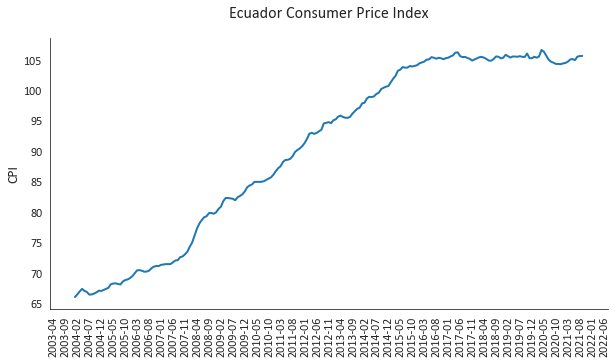

In [9]:
# Graph: IPC
fig, ax = plt.subplots(nrows = 1, ncols = 1)
sns.lineplot(data = df,
              x = 'date',
              y = 'ipc',
              linewidth = 2,
              color = my_palette2[0],
              ax = ax)
plt.title('Ecuador Consumer Price Index', fontsize = 16, pad = 20, **csfont)
plt.ylabel('CPI', fontsize = 14, **csfont)
plt.yticks(fontsize = 12, **csfont)
plt.xlabel('')
plt.xticks(fontsize = 12, rotation = 90, **csfont)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 5))

sns.despine()
plt.gcf().set_size_inches(10, 5);

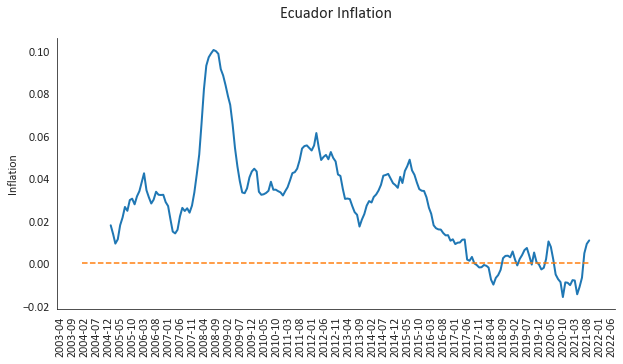

In [10]:
# Graph: Inflation
fig, ax = plt.subplots(nrows = 1, ncols = 1)
sns.lineplot(data = df,
              x = 'date',
              y = df['ipc'].pct_change(periods = 12), # Ecuador interannual inflation
              linewidth = 2,
              color = my_palette2[0],
              ax = ax)
sns.lineplot(data = df, x = 'date', y = 0, color = my_palette2[1], linestyle = '--')
plt.title('Ecuador Inflation', fontsize = 16, pad = 20, **csfont)
plt.ylabel('Inflation', fontsize = 12, **csfont)
plt.yticks(fontsize = 12, **csfont)
plt.xlabel('')
plt.xticks(fontsize = 12, rotation = 90, **csfont)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 5))
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())

sns.despine()
plt.gcf().set_size_inches(10, 5);

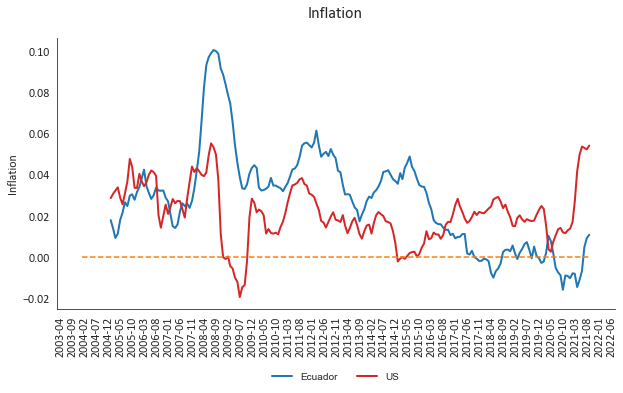

In [11]:
# Graph: Inflation (Ecuador vs US)
fig, ax = plt.subplots(nrows = 1, ncols = 1)
sns.lineplot(data = df,
              x = 'date',
              y = df['ipc'].pct_change(periods = 12), # Ecuador interannual inflation
              linewidth = 2,
              color = my_palette2[0],
              label = 'Ecuador',
              ax = ax)
sns.lineplot(data = df,
              x = 'date',
              y = df['CPI_US'].pct_change(periods = 12), # US interannual inflation
              linewidth = 2,
              color = my_palette2[3],
              label = 'US',
              ax = ax)
sns.lineplot(data = df, x = 'date', y = 0, color = my_palette2[1], linestyle = '--')
plt.title('Inflation', fontsize = 16, pad = 20, **csfont)
plt.ylabel('Inflation', fontsize = 12, **csfont)
plt.yticks(fontsize = 12, **csfont)
plt.xlabel('')
plt.xticks(fontsize = 12, rotation = 90, **csfont)

plt.legend(title = None,
           loc = 'upper center',
           bbox_to_anchor = (0.5, -0.2),
           ncol = 3,
           frameon = False)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 5))
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())

sns.despine()
plt.gcf().set_size_inches(10, 5);

In [12]:
# Correlation matrix
num_cols = df.drop(['date'], axis = 1).columns
df[num_cols].corr().head()

,ipc,ind_man,ind_com,ind_con,ind_ser,iae_np,ideac_ct,ideac_sb,base_mon,caja_bce,...,CPI_US,TNX,pos_divisas,oro_monetario,DEGs,pos_reserva_FMI,pos_ALADI,res_internacional,ipp,ipcons
ipc,1.000000,0.931881,0.906384,0.823421,0.846815,0.902907,0.954765,0.916484,0.902956,0.706139,...,0.951851,-0.863967,0.358788,0.437306,0.080685,0.861823,-0.181672,0.480010,0.979800,0.924084
ind_man,0.931881,1.000000,0.990449,0.941728,0.968617,0.994696,0.975246,0.945258,0.737803,0.768525,...,0.883488,-0.803591,0.446005,0.535261,0.100180,0.854029,-0.093874,0.597440,0.969198,0.959074
ind_com,0.906384,0.990449,1.000000,0.948346,0.978729,0.995589,0.954859,0.927928,0.712581,0.751213,...,0.868670,-0.768025,0.468716,0.522636,0.106233,0.817443,-0.069837,0.612732,0.948806,0.952131
ind_con,0.823421,0.941728,0.948346,1.000000,0.931697,0.961438,0.901619,0.880248,0.557359,0.718162,...,0.731207,-0.681585,0.491485,0.379980,0.112721,0.803066,-0.062427,0.595684,0.875490,0.879912
ind_ser,0.846815,0.968617,0.978729,0.931697,1.000000,0.984252,0.904280,0.877928,0.626877,0.735449,...,0.819815,-0.732520,0.485287,0.569654,0.108257,0.749825,-0.008948,0.642339,0.913933,0.948616


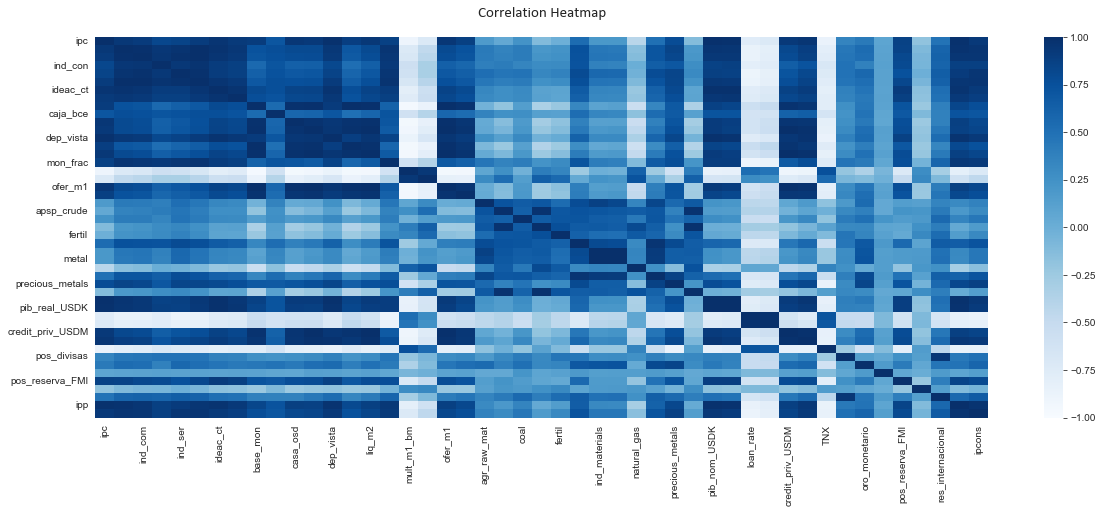

In [13]:
# Heatmap: Correlation matrix
fig, ax = plt.subplots(nrows = 1, ncols = 1)
sns.heatmap(df[num_cols].corr(),
            vmin = -1, vmax = 1,
            cmap = 'Blues')
plt.title('Correlation Heatmap', fontsize = 15, pad = 20, **csfont)
plt.gcf().set_size_inches(20, 7);

In [14]:
# Define function for scatter plots
def scatter_plot(data, x_var, y_var, color, title, x_label, y_label):
  
  fig, ax = plt.subplots(nrows = 1, ncols = 1)
  sns.scatterplot(data = data,
                  x = x_var,
                  y = y_var,
                  alpha = 0.4,
                  color = color)
  plt.title(f'{title}', fontsize = 16, pad = 20, **csfont)
  plt.xlabel(f'{x_label}', fontsize = 12, labelpad = 15, **csfont)
  plt.xticks(fontsize = 12, rotation = 90, **csfont)
  plt.ylabel(f'{y_label}', fontsize = 12, **csfont)
  plt.yticks(fontsize = 12, **csfont)

  sns.despine()
  plt.gcf().set_size_inches(10, 5);


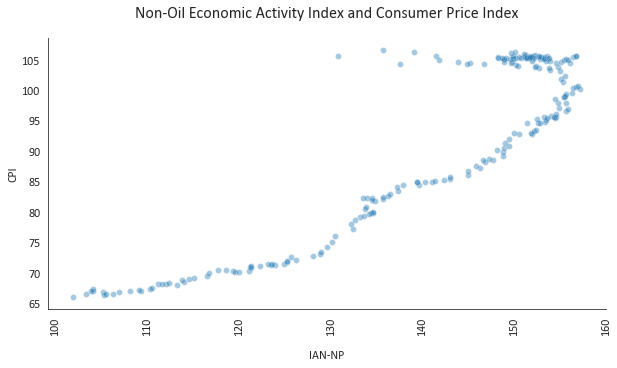

In [15]:
scatter_plot(df, 'iae_np', 'ipc', my_palette2[0], 
            'Non-Oil Economic Activity Index and Consumer Price Index', 
            'IAN-NP', 
            'CPI')

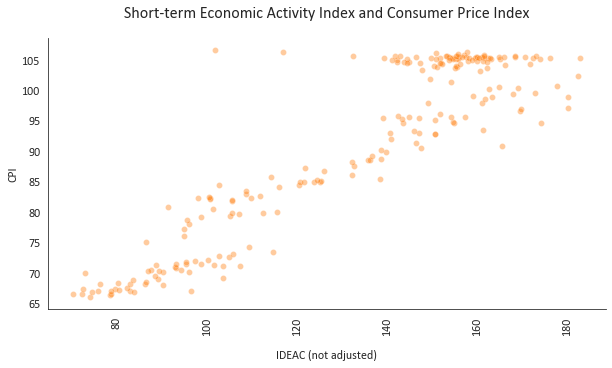

In [16]:
scatter_plot(df, 'ideac_sb', 'ipc', my_palette2[1], 
            'Short-term Economic Activity Index and Consumer Price Index', 
            'IDEAC (not adjusted)', 
            'CPI')

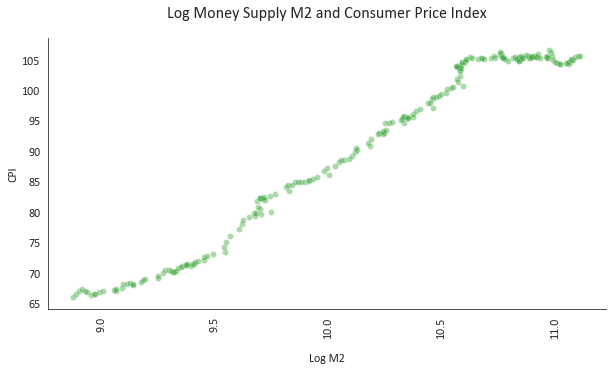

In [17]:
scatter_plot(df, np.log(df['liq_m2']), 'ipc', my_palette2[2], 
            'Log Money Supply M2 and Consumer Price Index', 
            'Log M2', 
            'CPI')

##### **Time Series treatment**

**Unit Root Test**

In [18]:
# Unit Root Test: Augmented Dickey-Fuller unit root test
# H0: there is a unit root

from statsmodels.tsa.stattools import adfuller;

C:\Users\fvill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\fvill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [19]:
# Dataframe that will contain the stationary series
df_stat = df[['date']].copy()

# Function to create stationary variables
def gen_stationary(var):
  if adfuller(df[var], autolag = 'AIC')[1] > 0.05: # If H0 is not rejected at the 95% confidence level
    df_stat[var + '_diff'] = df[var].diff()
  else:
    df_stat[var] = df[var]

In [20]:
# Evaluate each variable in the dataframe
for var in df.drop(['date'], axis = 1).columns:
  gen_stationary(var);

In [21]:
# Remove missing values in Ecuador CPI variable
df_stat = df_stat[df_stat['ipc_diff'].notna()]

df_stat.head()

,date,ipc_diff,ind_man_diff,ind_com_diff,ind_con_diff,ind_ser,iae_np_diff,ideac_ct_diff,ideac_sb_diff,base_mon_diff,...,CPI_US_diff,TNX_diff,pos_divisas,oro_monetario_diff,DEGs_diff,pos_reserva_FMI_diff,pos_ALADI_diff,res_internacional,ipp_diff,ipcons_diff
1,2004-02-01,0.45,3.546210,0.668855,0.678140,107.276700,1.434140,0.650352,-3.774256,25.919999,...,0.4,-0.066289,844.86,-3.29,-7.50,-0.02,0.42,1206.57,2.03,3.32
2,2004-03-01,0.47,1.427681,1.614885,0.367364,106.919136,0.741118,0.494428,12.551825,-114.177000,...,0.4,-0.257689,752.60,23.52,44.42,0.00,-0.63,1181.62,1.67,4.28
3,2004-04-01,0.43,0.575815,-0.368881,-0.283192,107.215493,0.034479,0.327072,-3.189030,13.916000,...,0.3,0.521097,867.16,-29.72,-30.06,-0.49,0.15,1236.06,-0.35,3.69
4,2004-05-01,-0.32,-1.868806,-0.045951,0.558103,107.619727,-0.194820,0.191546,-3.710760,91.460046,...,0.8,0.367881,866.90,4.00,-7.06,0.29,-0.05,1232.98,-0.65,4.55
5,2004-06-01,-0.20,1.701484,1.395899,1.635849,107.791548,1.260982,0.094894,-1.325310,45.623234,...,0.7,0.018310,849.38,2.16,-0.01,-0.02,-0.77,1216.81,-0.41,1.43


In [22]:
# Correlation matrix
num_cols = df_stat.drop(['date'], axis = 1).columns
df_stat[num_cols].corr().head()

,ipc_diff,ind_man_diff,ind_com_diff,ind_con_diff,ind_ser,iae_np_diff,ideac_ct_diff,ideac_sb_diff,base_mon_diff,caja_bce_diff,...,CPI_US_diff,TNX_diff,pos_divisas,oro_monetario_diff,DEGs_diff,pos_reserva_FMI_diff,pos_ALADI_diff,res_internacional,ipp_diff,ipcons_diff
ipc_diff,1.000000,0.009423,0.009845,0.000277,0.004398,0.010990,0.052844,-0.221017,-0.075886,0.048022,...,-0.006946,-0.033203,0.133017,0.113654,0.021946,0.039248,0.029572,0.113376,0.103436,0.315791
ind_man_diff,0.009423,1.000000,0.874425,0.784192,-0.032491,0.935315,0.265284,-0.006453,-0.089855,0.078593,...,0.102056,0.182046,0.026904,0.219601,0.008481,0.009337,-0.031756,0.058812,0.006698,0.100767
ind_com_diff,0.009845,0.874425,1.000000,0.848844,-0.003429,0.957355,0.160043,-0.061633,-0.152048,0.122957,...,0.025434,0.108565,0.004537,0.149926,-0.009712,-0.052434,-0.039135,0.022926,-0.046281,0.072240
ind_con_diff,0.000277,0.784192,0.848844,1.000000,0.034856,0.923613,0.142563,-0.074045,-0.177942,0.139201,...,0.071947,0.166135,0.046100,0.138719,0.010519,0.017680,-0.031608,0.075544,0.016668,0.126709
ind_ser,0.004398,-0.032491,-0.003429,0.034856,1.000000,-0.011932,-0.012997,-0.003171,0.062536,0.001425,...,-0.024030,-0.021134,0.475878,-0.038706,-0.002673,0.015870,-0.016128,0.634597,-0.052128,-0.188858


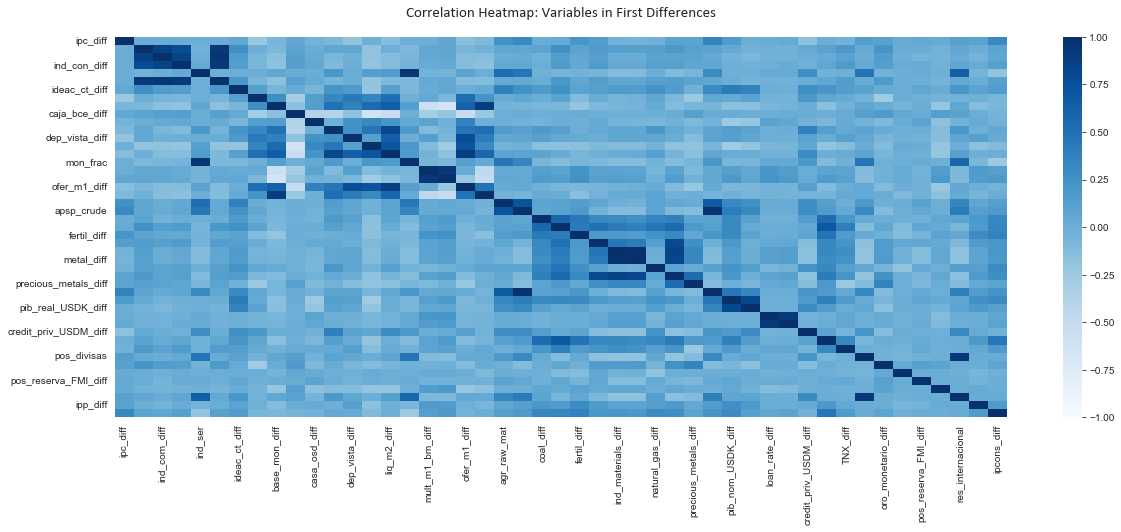

In [23]:
# Heatmap: Correlation matrix in first differences
fig, ax = plt.subplots(nrows = 1, ncols = 1)
sns.heatmap(df_stat[num_cols].corr(),
            vmin = -1, vmax = 1,
            cmap = 'Blues')
plt.title('Correlation Heatmap: Variables in First Differences', fontsize = 15, pad = 20, **csfont)
plt.gcf().set_size_inches(20, 7);

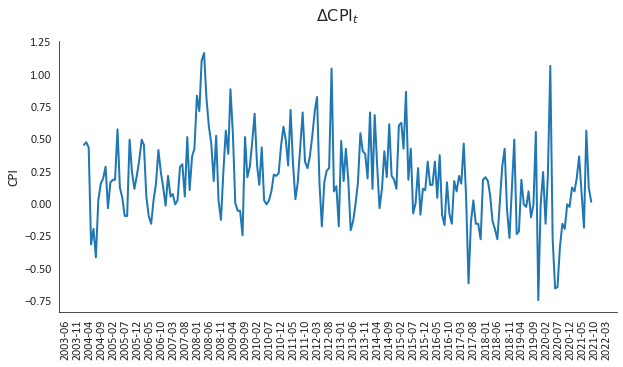

In [24]:
# Graph: CPI
fig, ax = plt.subplots(nrows = 1, ncols = 1)
sns.lineplot(data = df_stat,
              x = 'date',
              y = 'ipc_diff',
              linewidth = 2,
              color = my_palette2[0],
              ax = ax)
plt.title('$\Delta\mathrm{CPI}_{t}$', fontsize = 16, pad = 20, **csfont)
plt.ylabel('CPI', fontsize = 14, **csfont)
plt.yticks(fontsize = 12, **csfont)
plt.xlabel('')
plt.xticks(fontsize = 12, rotation = 90, **csfont)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 5))

sns.despine()
plt.gcf().set_size_inches(10, 5);

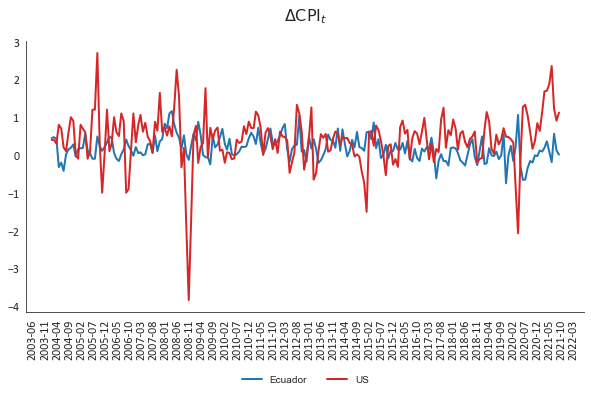

In [25]:
# Graph: CPI (Ecuador vs US)
fig, ax = plt.subplots(nrows = 1, ncols = 1)
sns.lineplot(data = df_stat,
              x = 'date',
              y = 'ipc_diff',
              linewidth = 2,
              color = my_palette2[0],
              label = 'Ecuador',
              ax = ax)
sns.lineplot(data = df_stat,
              x = 'date',
              y = 'CPI_US_diff',
              linewidth = 2,
              color = my_palette2[3],
              label = 'US',
              ax = ax)
plt.title('$\Delta\mathrm{CPI}_{t}$', fontsize = 16, pad = 20, **csfont)
plt.ylabel('', fontsize = 14, **csfont)
plt.yticks(fontsize = 12, **csfont)
plt.xlabel('')
plt.xticks(fontsize = 12, rotation = 90, **csfont)

plt.legend(title = None,
           loc = 'upper center',
           bbox_to_anchor = (0.5, -0.2),
           ncol = 3,
           frameon = False)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 5))

sns.despine()
plt.gcf().set_size_inches(10, 5);

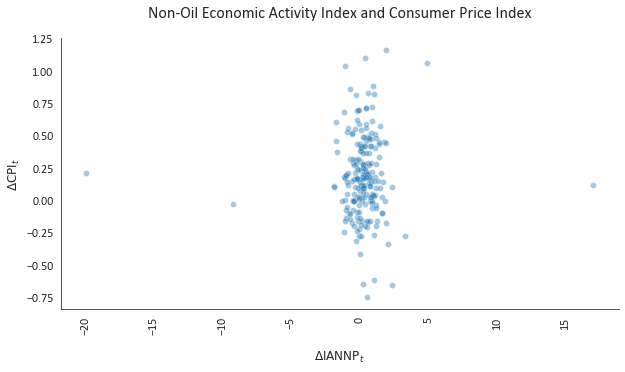

In [26]:
scatter_plot(df_stat, 'iae_np_diff', 'ipc_diff', my_palette2[0], 
            'Non-Oil Economic Activity Index and Consumer Price Index', 
            '$\Delta\mathrm{IANNP}_{t}$', 
            '$\Delta\mathrm{CPI}_{t}$')